In [ ]:
from os import environ
environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import mediapipe as mp
import cv2 as cv
import numpy as np
import pyautogui
from pynput.mouse import Button, Controller
import time

In [ ]:
mouse = Controller()

In [ ]:
screen_width, screen_height = pyautogui.size()

# MediaPipe's trained hand model
hands = mp.solutions.hands.Hands(
    static_image_mode=False,         # False = video stream input (not static images); enables tracking for better performance
    model_complexity=1,              # controls model's accuracy vs speed -> 0 = fast, 1 = balanced (default), 2 = slow but more accurate
    min_detection_confidence=0.7,    # Minimum confidence to detect a new hand; increase to reduce false positives
    min_tracking_confidence=0.7,     # Minimum confidence to continue tracking detected hands across frames
    max_num_hands=1                  # Max number of hands to detect and track at once (set to 2 for both hands)
)

In [ ]:
def landmark_distance(landmark1, landmark2):
    x1, y1 = landmark1
    x2, y2 = landmark2
    dist = np.hypot(x2 - x1, y2 - y1)
    
    return np.interp(dist, [0, 1], [0, 1000])

def get_angle(a, b, c):
    radians = np.arctan2(c[1] - b[1], c[0] - b[0]) - np.arctan2(a[1] - b[1], a[0] - b[0])
    angle = np.abs(np.degrees(radians))

    return angle

In [ ]:
def move_mouse(index_finger_tip):
    if index_finger_tip is not None:
        # convert landmarks' coords to screen coords
        x = int(index_finger_tip[0] * screen_width)
        y = int(index_finger_tip[1] * screen_height)

        pyautogui.moveTo(x, y)

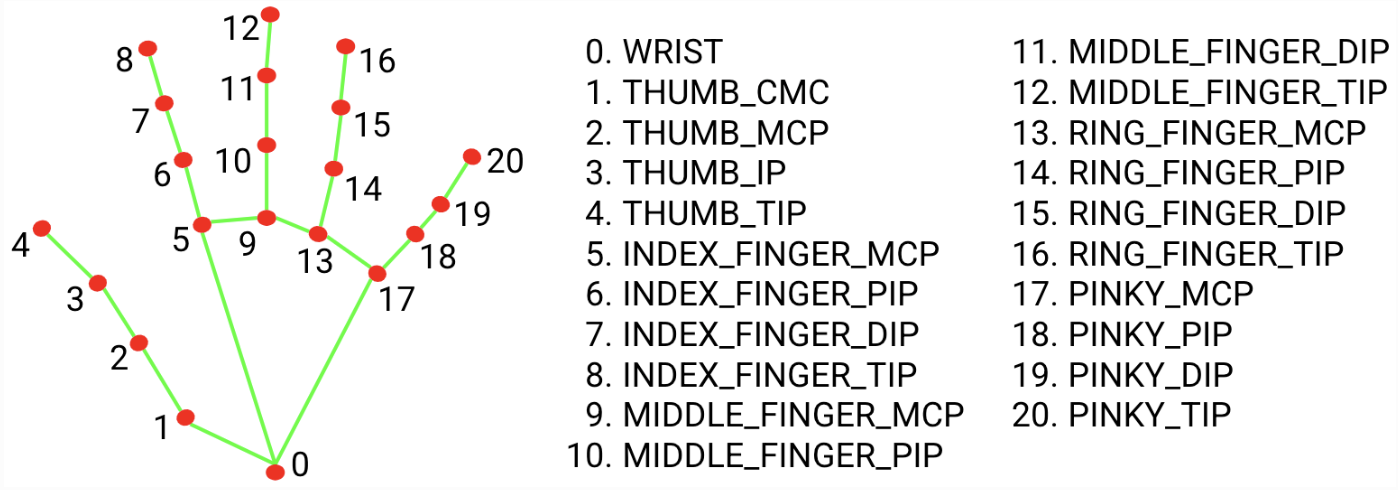

`thumb_index_distance` is the distance between landmarks **4** and **5**

In [ ]:
def detect_gestures(landmarks) -> str:
    '''
    Based on the landmark coordinates, detects, performs, and returns the corresponding mouse action.
    '''

    index_finger_tip_coords = landmarks[8]
    thumb_index_distance = landmark_distance(landmarks[4], landmarks[5])

    # move cursor
    # check for thumb near index finger and index finger upright
    if thumb_index_distance < 50 and get_angle(landmarks[5], landmarks[6], landmarks[8]) > 90: # index finger upright position
        move_mouse(index_finger_tip_coords)
        return 'move'

    # left click
    # check for thumb away from index finger, index finger bent, and middle finger upright
    elif thumb_index_distance > 50 and get_angle(landmarks[5], landmarks[6], landmarks[8]) < 100 and get_angle(landmarks[9], landmarks[10], landmarks[12]) > 90:
        mouse.press(Button.left)
        mouse.release(Button.left)
        return 'left click'

    # right click
    # check for thumb away from index finger, index finger upright, and middle finger bent
    elif thumb_index_distance > 50 and get_angle(landmarks[5], landmarks[6], landmarks[8]) > 90 and get_angle(landmarks[9], landmarks[10], landmarks[12]) < 50:
        mouse.press(Button.right)
        mouse.release(Button.right)
        return 'right click'

    # double click
    # check for thumb away from index finger, index finger bent, and middle finger bent
    elif thumb_index_distance > 50 and get_angle(landmarks[5], landmarks[6], landmarks[8]) < 80 and get_angle(landmarks[9], landmarks[10], landmarks[12]) < 80:
        pyautogui.doubleClick()
        return 'double click'

    # screenshot
    # check for thumb near index finger, index finger bent, and middle finger bent
    elif thumb_index_distance < 50 and get_angle(landmarks[5], landmarks[6], landmarks[8]) < 50 and get_angle(landmarks[9], landmarks[10], landmarks[12]) < 50:
        image = pyautogui.screenshot()
        image.save(f"/Users/dhruv/Desktop/{time.time()}.png")
        return 'screenshot'
    
    return ''

In [ ]:
stream = cv.VideoCapture(0)
draw = mp.solutions.drawing_utils

while stream.isOpened():
    readable, frame = stream.read()

    if not readable:
        break

    # flip frame
    frame = cv.flip(frame, 1)

    frame_rgb = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    processed = hands.process(frame_rgb) # processing occurs on RGB frame
    
    landmarks = [] # store all 21 hand keypoints

    # check if hand was detected in the frame; evaluates to None if no hands detected
    if processed.multi_hand_landmarks:
        
        hand_landmarks = processed.multi_hand_landmarks[0] # only processing the first/one hand
        draw.draw_landmarks(frame, hand_landmarks, mp.solutions.hands.HAND_CONNECTIONS) # draw 21 keypoints on the frame to display

        for landmark in hand_landmarks.landmark:
            landmarks.append((landmark.x, landmark.y)) # landmarks contains the normalized (x,y) coords of the hand's 21 keypoints
    
        # detect gesture from the landmark coords
        action = detect_gestures(landmarks)
        
        # write gesture on frame for user feedback
        cv.putText(frame, action, (350, 150), cv.FONT_HERSHEY_SCRIPT_SIMPLEX, 2.0, (0, 0, 255), 4)

    # display the frame
    cv.imshow('Processing', frame)

    # press 'q' to stop the program
    if cv.waitKey(10) & 0xff == ord('q'):
        break

# release resources
stream.release()
cv.destroyAllWindows()

**Hand landmarks can be used to:**

1. **Count raised fingers**  
2. **Recognize gestures**  
3. **Calculate angles between joints**  
4. **Map hand position on screen**
